In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#hide
import matplotlib.pyplot as plt

In [ ]:
#export
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [ ]:
# default_exp local_feature_importance

# TODOs

- Add factory class which prepares object for XGBoost and LightGBM.
- Add example for classification example.

# Local Feature Importance

> Give GBDT model ( XGBoost or LightGBM ) and a specific instance this class would calculate the relationship of different features with a specific instance.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
class XGBoostLFI:
    "Wrapper around for `XGBoost` models"
    def __init__(self, model):
        self.model = model
        
    def get_tree(self, trees, tree_index):
        "Return tree for a specific index."
        mask = trees.Tree == tree_index
        return trees.loc[mask]
    
    def get_booster(self): 
        "Returns booster."
        return self.model.get_booster()
    
    def get_num_trees(self, trees_df): 
        "Returns number of number of estimators."
        return trees_df.Tree.nunique()
    
    def get_node(self, tree, node_id):
        "Returns a particular node in a tree."
        mask = tree.ID == node_id
        return tree.loc[mask]
    
    def get_node_index(self, node, branch):
        "Returns index of a particular node in a tree."
        if branch == 'left': return node['Yes'].values[0]
        else: return node['No'].values[0]
        
    def get_node_id(self, node): 
        "Returns id of a particular node in a tree. It is different from a node-index."
        return node['ID'].values[0]
        
    def next_node(self, tree, curr_node, branch):
        "Returns next node from a current node based on which sub-branch one wants to navigate."
        if branch == 'left': return self.get_node(tree, self.get_node_index(curr_node, branch))
        else: return self.get_node(tree, self.get_node_index(curr_node, branch))
    
    def get_split(self, node): 
        "Returns split value"
        return node['Split'].values[0]
    
    def get_feature(self, node): 
        "Returns feature that was used to make the split."
        return node['Feature'].values[0]
    
    def node_score(self, node): 
        "Returns gain for a particular decision node."
        return node['Gain'].values[0]
    
    def node_parent_score(self, node): 
        "Returns parent score for a particular node"
        return node['Parent_Score'].values[0]
    
    def node_cover(self, node): 
        "Returns how many samples are there in a terminal node."
        return node['Cover'].values[0]
    
    def average(self, left_node, right_node):
        "Returns average of scores of children of a node."
        return (left_node['score'] + right_node['score']) / 2
    
    def weighted_sum(self, left_node, right_node):
        "Returns weighted average of children of a node."
        return ((left_node['cover'] * left_node['score'] + right_node['cover'] * right_node['score'])) /\
                (left_node['cover'] + right_node['cover'])
    
    def propagation_strategy(self, left_node, right_node, strategy='average'):
        "Returns parent score from left and right children. It is based on propagation strategy."
        if strategy == 'average': return self.average(left_node, right_node)
        else: return self.weighted_sum(left_node, right_node)

In [ ]:
class LocalFeatureImportance:
    "Calculates `Feature Importance` and provides explanability. It implements (http://www.cs.sjtu.edu.cn/~kzhu/papers/kzhu-infocode.pdf)"
    def __init__(self, model, strategy='average'):
        self.strategy = strategy
        model_category = self.get_model_category(self.get_model_type(model))
        
        if model_category == 'xgboost':
            self.model = XGBoostLFI(model)
    
    def trees_to_df(self):
        "Convert internal tree reprensentation to a Pandas DataFrame"
        if self.get_model_type(self.model) == xgb.core.Booster: return self.model.trees_to_dataframe()
        else: return self.model.get_booster().trees_to_dataframe()
    
    def get_model_type(self, model):
        return type(model)
    
    def get_model_category(self, model_type):
        if model_type in [xgb.core.Booster, xgb.sklearn.XGBRegressor, xgb.sklearn.XGBClassifier]:
            return 'xgboost'
        else:
            raise ValueError(f'{model_type} is not supported.')
    
    def make_node(self, node):
        "Create dict representation of a node which contains score and cover based on strategy."
        if self.strategy == 'average': return {'score': self.model.node_parent_score(node)}
        else: return {'score': self.model.node_parent_score(node), 'cover': self.model.node_cover(node)}
    
    def parse(self, tree, node_id):
        "Calculates and assigns scores for a particular node in the tree."
        current_node = self.model.get_node(tree, node_id)
        
        if self.model.get_feature(current_node) == 'Leaf': return self.model.node_score(current_node)
        
        left_child  = self.model.next_node(tree, current_node, branch='left')
        right_child = self.model.next_node(tree, current_node, branch='right')
        
        left_branch_score = self.parse(tree, self.model.get_node_id(left_child))
        tree.loc[tree.ID == left_child.ID.values[0], 'Parent_Score'] = left_branch_score

        right_branch_score = self.parse(tree, self.model.get_node_id(right_child))
        tree.loc[tree.ID == right_child.ID.values[0], 'Parent_Score'] = right_branch_score
        
        root_score = self.model.propagation_strategy(self.make_node(self.model.get_node(tree,
                                                                                self.model.get_node_index(current_node, branch='left')
                                                                               )),
                                                     self.make_node(self.model.get_node(tree,
                                                                                    self.model.get_node_index(current_node, branch='right')
                                                                               )))
        
        tree.loc[tree.ID == current_node.ID.values[0], 'Parent_Score'] = root_score
        return root_score
        
    def propagate_scores(self):
        "Parse and calculates scores for all nodes for all trees."
        trees_df = self.trees_to_df()
        parsed_trees = []
        num_trees = self.model.get_num_trees(trees_df)
        
        for tree_index in range(num_trees):
            tree = self.model.get_tree(trees_df, tree_index)
            self.parse(tree, f'{tree_index}-0')
            parsed_trees.append(tree)
        
        return pd.concat(parsed_trees, axis=0)
    
    def split_decision(self, feature, split_value):
        "How to make decide whether to go left or right in a tree."
        if pd.isnull(feature): return True
        elif feature <= split_value: return True
        else: return False
    
    def walk(self, tree, node_id, test, feature_contribution):
        "Walks through the tree for a specific instance and returns relationship between features and instance."
        current_node = self.model.get_node(tree, node_id)
        feature = self.model.get_feature(current_node)
        
        if feature == 'Leaf': return

        if self.split_decision(test[feature].values[0], self.model.get_split(current_node)):
            left_child = self.model.next_node(tree, current_node, branch='left')
            
            t = self.model.node_parent_score(left_child) - self.model.node_parent_score(current_node)
            feature_contribution[feature].append(t)
            self.walk(tree, self.model.get_node_id(left_child), test, feature_contribution)
        else:
            right_child = self.model.next_node(tree, current_node, branch='right')
            
            t = self.model.node_parent_score(right_child) - self.model.node_parent_score(current_node)
            feature_contribution[feature].append(t)
            self.walk(tree, self.model.get_node_id(right_child), test, feature_contribution)
            
        return feature_contribution
    
    def index_to_feat(self, feats):
        "Maps features to indices."
        return {i:f for i, f in enumerate(feats)}
    
    def get_fi(self, trees, x_test):
        "Calculates feature importance by aggregating over all samples over all trees."
        itof = self.index_to_feat(x_test.columns.tolist())
        fc_over_sample = np.zeros(shape=(x_test.shape[1], x_test.shape[0]))
        
        for index in range(x_test.shape[0]):
            num_trees = self.model.get_num_trees(trees)
            contribution = defaultdict(int)
                
            for tree_index in range(num_trees):
                feature_contribution = defaultdict(list)
                tree = self.model.get_tree(trees, tree_index)
                
                fc = self.walk(tree, f'{tree_index}-0', x_test[index:index+1], feature_contribution)
                
                for f, l in fc.items():
                    contribution[f] += (np.sum(l) / num_trees)
            
            fc_over_sample[:, index] = np.array([contribution[itof[i]] if itof[i] in contribution else 0 for i in range(x_test.shape[1])])
        
        return fc_over_sample

## Usage

In [ ]:
x,y = make_regression(n_samples=1000,n_features=6,n_informative=3)
xtr, xval, ytr, yval = train_test_split(x, y, test_size=0.5, random_state=41)

In [ ]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10, max_depth=4)
model.fit(xtr,ytr)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

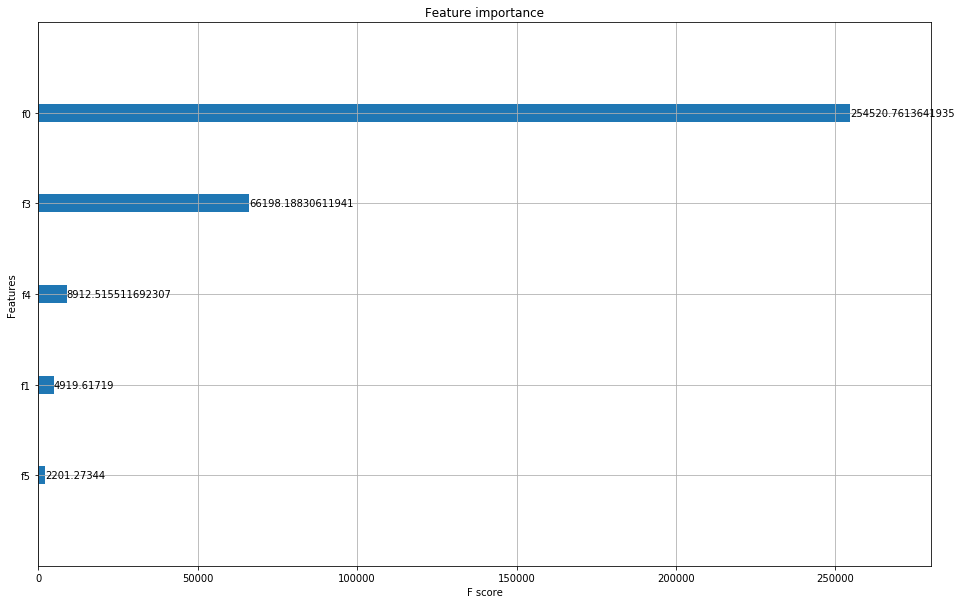

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 10))
xgb.plot_importance(model, importance_type='gain', ax=ax);

In [ ]:
lfi     = LocalFeatureImportance(model)
scores  = lfi.propagate_scores()

In [ ]:
scores.head()

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Parent_Score
0,0,0,0-0,f0,-0.159498,0-1,0-2,0-1,2241794.750,500.0,-1.365281
1,0,1,0-1,f0,-1.221669,0-3,0-4,0-3,273895.750,216.0,-8.216369
2,0,2,0-2,f0,0.769237,0-5,0-6,0-5,611977.812,284.0,5.485807
3,0,3,0-3,f3,0.496709,0-7,0-8,0-7,48393.500,60.0,-11.909896
4,0,4,0-4,f3,-0.085148,0-9,0-10,0-9,229686.094,156.0,-4.522841


In [ ]:
si = pd.DataFrame(xval, columns=['f0', 'f1', 'f2', 'f3', 'f4', 'f5']).sample(n=1)

In [ ]:
model.predict(si)

array([77.93277], dtype=float32)

In [ ]:
pd.Series(ytr).describe()

count    500.000000
mean      -0.159812
std       97.813910
min     -264.029216
25%      -67.289598
50%       -0.195855
75%       64.315742
max      265.985229
dtype: float64

In [ ]:
fc = tmp_lfi.get_fi(scores, )

In [ ]:
fc

array([[-5.44675432],
       [ 0.        ],
       [ 0.        ],
       [-1.29900827],
       [-0.44857899],
       [ 0.        ]])

In [ ]:
np.apply_along_axis(np.median, axis=1, arr=fc)

array([-5.44675432,  0.        ,  0.        , -1.29900827, -0.44857899,
        0.        ])

In [ ]:
tree_df = model.get_booster().trees_to_dataframe()

In [ ]:
tree_df

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
0,0,0,0-0,f0,-0.513885,0-1,0-2,0-1,276863.438000,50.0
1,0,1,0-1,f0,-1.004093,0-3,0-4,0-3,12667.078100,14.0
2,0,2,0-2,f0,0.628103,0-5,0-6,0-5,79735.921900,36.0
3,0,3,0-3,Leaf,NaN,NaN,NaN,NaN,-13.944529,9.0
4,0,4,0-4,Leaf,NaN,NaN,NaN,NaN,-5.736783,5.0
5,0,5,0-5,Leaf,NaN,NaN,NaN,NaN,0.854307,23.0
6,0,6,0-6,Leaf,NaN,NaN,NaN,NaN,10.467960,13.0
7,1,0,1-0,f0,-0.513885,1-1,1-2,1-1,229293.656000,50.0
8,1,1,1-1,f1,-0.282982,1-3,1-4,1-3,11992.875000,14.0
9,1,2,1-2,f0,0.414512,1-5,1-6,1-5,66116.828100,36.0


In [ ]:
sample = pd.DataFrame([[-1.85947525, 0.16143727]], columns=['f0', 'f1']); sample.head()

,f0,f1
0,-1.859475,0.161437


In [ ]:
sample_tree_df = pd.DataFrame({
    'ID': ['0-0', '0-1', '0-2', '0-3', '0-4', '0-5', '0-6'],
    'Feature': ['f1', 'f1', 'f1', 'Leaf', 'Leaf', 'Leaf', 'Leaf'],
    'Yes': ['0-1', '0-3', '0-5', np.nan, np.nan, np.nan, np.nan],
    'No': ['0-2', '0-4', '0-6', np.nan, np.nan, np.nan, np.nan],
    'Split': [-.124077, -0.866319, 0.848756, np.nan, np.nan, np.nan, np.nan],
    'Gain': [291394.219000, 48918.625, 62176.6328, -12.440311, -3.014019, 2.790857, 12.667572]
}); sample_tree_df

,ID,Feature,Yes,No,Split,Gain
0,0-0,f1,0-1,0-2,-0.124077,291394.219000
1,0-1,f1,0-3,0-4,-0.866319,48918.625000
2,0-2,f1,0-5,0-6,0.848756,62176.632800
3,0-3,Leaf,NaN,NaN,NaN,-12.440311
4,0-4,Leaf,NaN,NaN,NaN,-3.014019
5,0-5,Leaf,NaN,NaN,NaN,2.790857
6,0-6,Leaf,NaN,NaN,NaN,12.667572


In [ ]:
big_tree_df = pd.DataFrame({
    'ID': ['0-0', '0-1', '0-2', '0-3', '0-4', '0-5', '0-6', '0-7', '0-8', '0-9', '0-10', '0-11',
           '0-12', '0-13', '0-14'
          ],
    'Feature': ['f5', 'f4', 'f2', 'Leaf', 'f4', 'f4', 'f5', 'Leaf', 'Leaf', 'f4', 'Leaf', 'Leaf',
                'Leaf', 'Leaf', 'Leaf'
               ],
    'Yes': ['0-1', '0-3', '0-5', np.nan, '0-7', '0-9', '0-11', np.nan, np.nan, '0-13', np.nan, np.nan,
            np.nan, np.nan, np.nan
           ],
    'No': ['0-2', '0-4', '0-6', np.nan, '0-8', '0-10', '0-12', np.nan, np.nan, '0-14', np.nan, np.nan,
           np.nan, np.nan, np.nan
          ],
    'Split': [-0.5, 1.5, 0.5, np.nan, 2.5, 3.5, 1.5, np.nan, np.nan, 2.5, np.nan, np.nan,
              np.nan, np.nan, np.nan
             ],
    'Gain': [np.nan, np.nan, np.nan, 0.136, np.nan, np.nan, np.nan, 0.079, 0.089, np.nan, 0.064, 0.085, 
             0.069, 0.060, 0.062
            ]
}); big_tree_df


,ID,Feature,Yes,No,Split,Gain
0,0-0,f5,0-1,0-2,-0.5,NaN
1,0-1,f4,0-3,0-4,1.5,NaN
2,0-2,f2,0-5,0-6,0.5,NaN
3,0-3,Leaf,NaN,NaN,NaN,0.136
4,0-4,f4,0-7,0-8,2.5,NaN
5,0-5,f4,0-9,0-10,3.5,NaN
6,0-6,f5,0-11,0-12,1.5,NaN
7,0-7,Leaf,NaN,NaN,NaN,0.079
8,0-8,Leaf,NaN,NaN,NaN,0.089
9,0-9,f4,0-13,0-14,2.5,NaN


In [ ]:
def get_node(tree, node_id): return tree.loc[tree.ID == node_id]
def parse(tree, node_id):
    root_node = get_node(tree, node_id)
    
    if root_node['Feature'].values[0] == 'Leaf': return root_node['Gain'].values[0]
    
    left_child  = get_node(tree, root_node['Yes'].values[0])
    right_child = get_node(tree, root_node['No'].values[0])
    
    left_subtree_score = parse(tree, left_child['ID'].values[0])
    tree.loc[tree.ID == left_child.ID.values[0], 'Parent_Score'] = left_subtree_score

    right_subtree_score = parse(tree, right_child['ID'].values[0])
    tree.loc[tree.ID == right_child.ID.values[0], 'Parent_Score'] = right_subtree_score

    root_score = (left_subtree_score + right_subtree_score) / 2
    tree.loc[tree.ID == root_node.ID.values[0], 'Parent_Score'] = root_score
    return root_score

In [ ]:
tmp = big_tree_df.copy()

tree_scores = parse(tmp, '0-0')

root node:     ID Feature  Yes   No  Split  Gain
0  0-0      f5  0-1  0-2   -0.5   NaN
root node:     ID Feature  Yes   No  Split  Gain
1  0-1      f4  0-3  0-4    1.5   NaN
root node:     ID Feature  Yes   No  Split   Gain
3  0-3    Leaf  NaN  NaN    NaN  0.136
root node:     ID Feature  Yes   No  Split  Gain  Parent_Score
4  0-4      f4  0-7  0-8    2.5   NaN           NaN
root node:     ID Feature  Yes   No  Split   Gain  Parent_Score
7  0-7    Leaf  NaN  NaN    NaN  0.079           NaN
root node:     ID Feature  Yes   No  Split   Gain  Parent_Score
8  0-8    Leaf  NaN  NaN    NaN  0.089           NaN
root node:     ID Feature  Yes   No  Split  Gain  Parent_Score
2  0-2      f2  0-5  0-6    0.5   NaN           NaN
root node:     ID Feature  Yes    No  Split  Gain  Parent_Score
5  0-5      f4  0-9  0-10    3.5   NaN           NaN
root node:     ID Feature   Yes    No  Split  Gain  Parent_Score
9  0-9      f4  0-13  0-14    2.5   NaN           NaN
root node:       ID Feature  Yes   No

In [ ]:
tmp


,ID,Feature,Yes,No,Split,Gain,Parent_Score
0,0-0,f5,0-1,0-2,-0.5,NaN,0.089875
1,0-1,f4,0-3,0-4,1.5,NaN,0.110000
2,0-2,f2,0-5,0-6,0.5,NaN,0.069750
3,0-3,Leaf,NaN,NaN,NaN,0.136,0.136000
4,0-4,f4,0-7,0-8,2.5,NaN,0.084000
5,0-5,f4,0-9,0-10,3.5,NaN,0.062500
6,0-6,f5,0-11,0-12,1.5,NaN,0.077000
7,0-7,Leaf,NaN,NaN,NaN,0.079,0.079000
8,0-8,Leaf,NaN,NaN,NaN,0.089,0.089000
9,0-9,f4,0-13,0-14,2.5,NaN,0.061000


In [ ]:
from collections import defaultdict

In [ ]:
def walk(tree_scores, node_id, test):
    root_node = get_node(tree_scores, node_id)
    feature = root_node['Feature'].values[0]
    
    if root_node['Feature'].values == 'Leaf':
        return
    
    if test[feature].values[0] <= root_node['Split'].values[0]:
        left_child = get_node(tree_scores, root_node['Yes'].values[0])
        
        t = left_child["Parent_Score"].values[0] - root_node["Parent_Score"].values[0]
        feature_contribution[feature].append(t)
        walk(tree_scores, left_child.ID.values[0], test)
    else:
        right_child = get_node(tree_scores, root_node['No'].values[0])
        
        t = right_child["Parent_Score"].values[0] - root_node["Parent_Score"].values[0] 
        feature_contribution[feature].append(t)
        walk(tree_scores, right_child.ID.values[0], test)

In [ ]:
sample_big = pd.DataFrame([[0.4, 3, 0.8]], columns=['f2', 'f4', 'f5'
                                       ]); sample_big.head()

,f2,f4,f5
0,0.4,3,0.8


In [ ]:
feature_contribution = defaultdict(list)
walk(tmp, '0-0', sample_big)

In [ ]:
feature_contribution

defaultdict(list,
            {'f5': [-0.020125000000000004],
             'f2': [-0.0072500000000000064],
             'f4': [-0.0015000000000000013, 0.0010000000000000009]})

In [ ]:
model.predict([[-1.85947525, 0.16143727]])

array([3.8834105], dtype=float32)

In [ ]:
model.get_booster().feature_names

['f0', 'f1']

### Compare with global feature importance

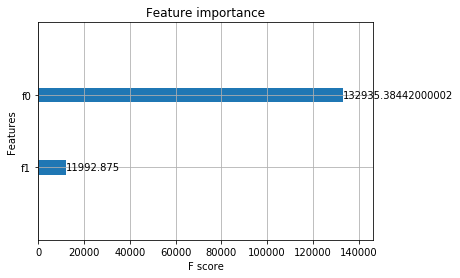

In [ ]:
xgb.plot_importance(model, importance_type='gain');

In [ ]:
tmp = tree_df.copy()

tree_scores = parse(tmp, '0-0')

In [ ]:
tmp

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Parent_Score
0,0,0,0-0,f0,-0.513885,0-1,0-2,0-1,276863.438000,50.0,-2.089761
1,0,1,0-1,f0,-1.004093,0-3,0-4,0-3,12667.078100,14.0,-9.840656
2,0,2,0-2,f0,0.628103,0-5,0-6,0-5,79735.921900,36.0,5.661134
3,0,3,0-3,Leaf,NaN,NaN,NaN,NaN,-13.944529,9.0,-13.944529
4,0,4,0-4,Leaf,NaN,NaN,NaN,NaN,-5.736783,5.0,-5.736783
5,0,5,0-5,Leaf,NaN,NaN,NaN,NaN,0.854307,23.0,0.854307
6,0,6,0-6,Leaf,NaN,NaN,NaN,NaN,10.467960,13.0,10.467960
7,1,0,1-0,f0,-0.513885,1-1,1-2,1-1,229293.656000,50.0,NaN
8,1,1,1-1,f1,-0.282982,1-3,1-4,1-3,11992.875000,14.0,NaN
9,1,2,1-2,f0,0.414512,1-5,1-6,1-5,66116.828100,36.0,NaN


In [ ]:
feature_contribution = defaultdict(list)
walk(tmp, '0-0', pd.DataFrame(x, columns=['f0', 'f1']))

In [ ]:
feature_contribution

defaultdict(list, {'f0': [7.75089493675, -4.8068267915]})